In [20]:
from PIL import Image
import numpy as np
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

import matplotlib.pyplot as plt

plt.rcParams["image.origin"] = "lower"
# plt.style.use("dark_background")  # Optional!

In [6]:
spectrum_filename = "aldebaran_3s_1.bmp"

image_data = Image.open(spectrum_filename)

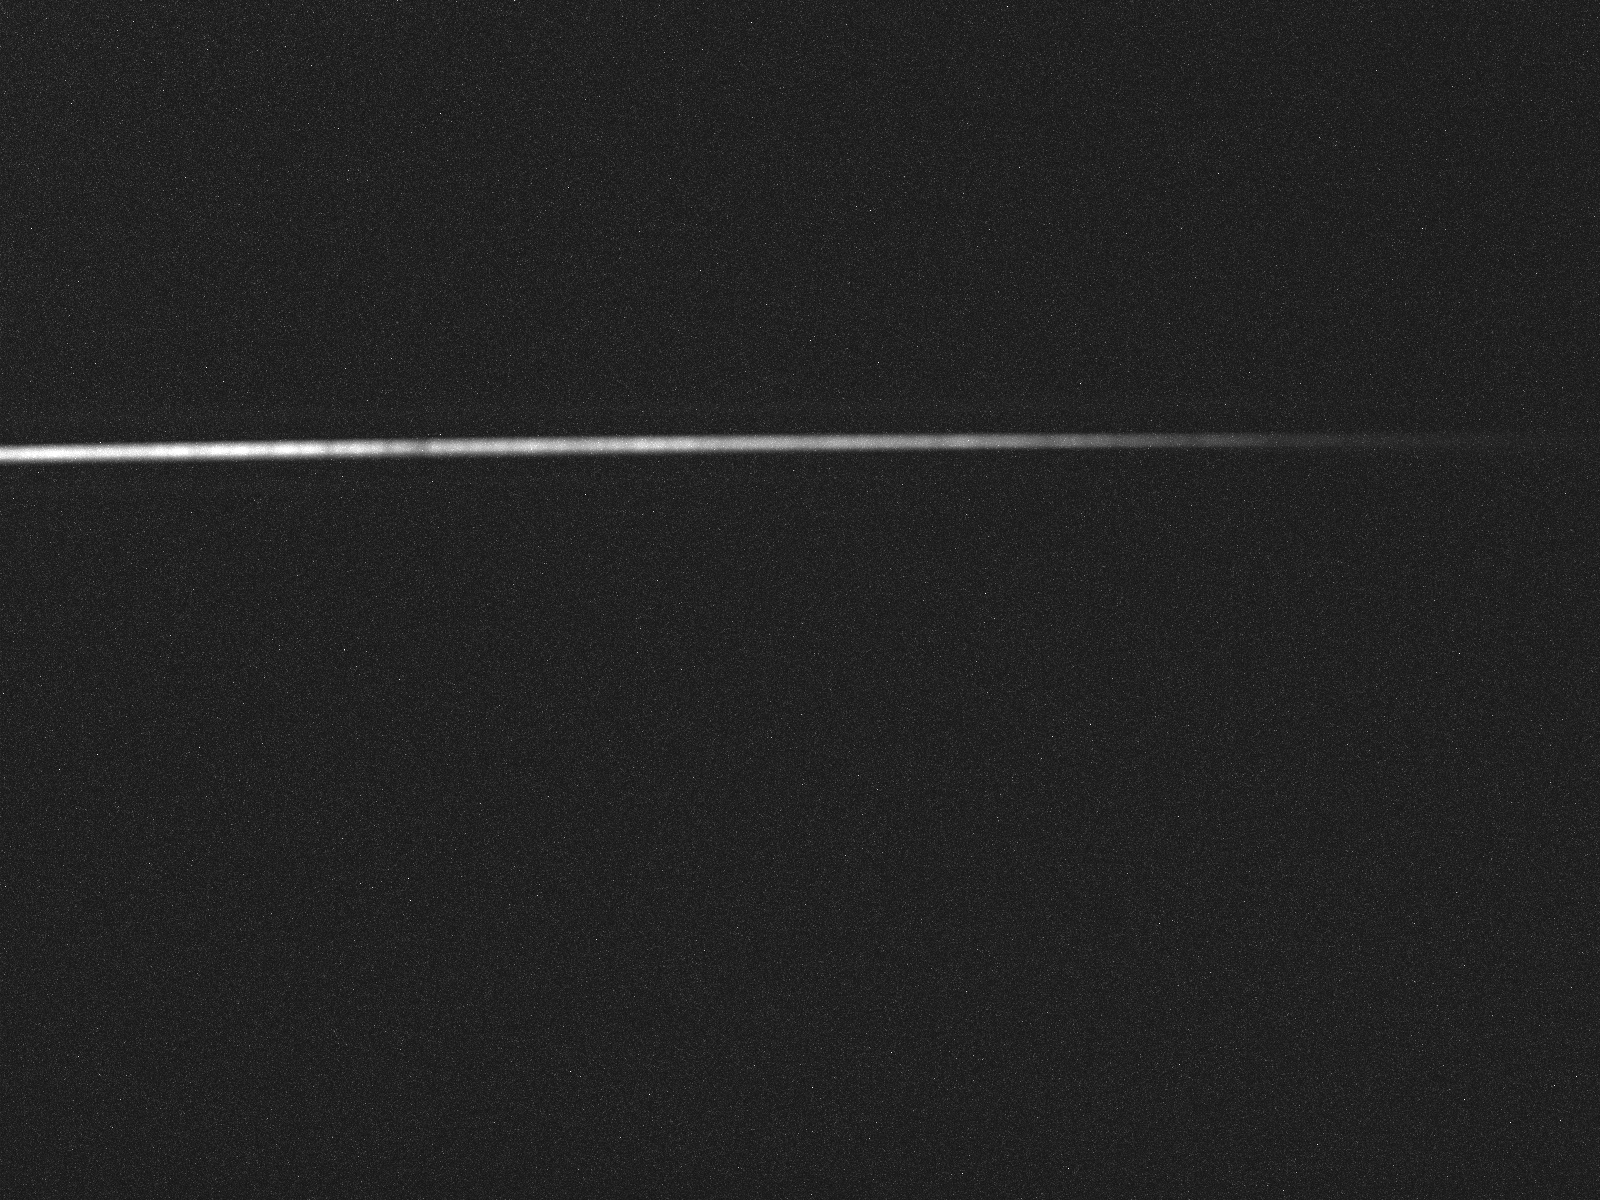

In [7]:
image_data

In [8]:
# our data are unsigned 8-bit integers (0-255) representing a monochromatic image
# we can see this by printing the array version of the image
# we can also see its shape, verifying that it is indeed 2-dimensional
image_array = np.array(image_data)
image_array, image_array.shape

(array([[41, 43, 50, ..., 52, 28, 27],
        [33, 22, 48, ..., 37, 35, 26],
        [41, 64, 30, ..., 21, 30, 33],
        ...,
        [33, 28, 27, ..., 26, 33, 28],
        [35, 25, 23, ..., 23, 46, 46],
        [32, 35, 22, ..., 23, 40, 29]], shape=(1200, 1600), dtype=uint8),
 (1200, 1600))

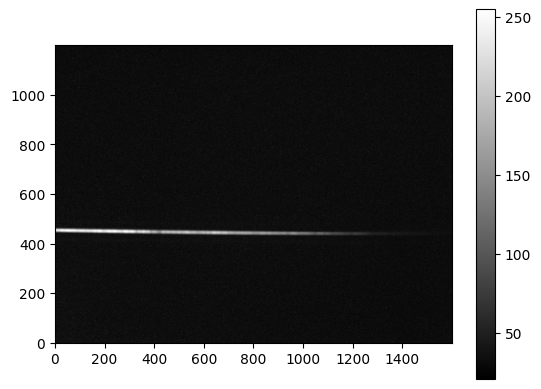

In [9]:
# but we'd like to see it with axes labeled
plt.imshow(image_data, cmap="gray")
plt.colorbar();  # the semicolon at the end of the last line prevents ipython from printing out the object

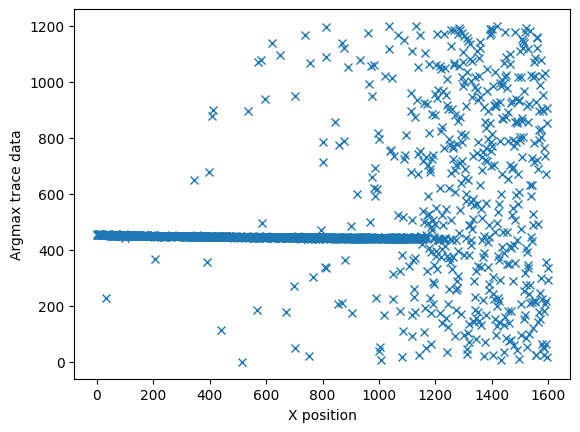

In [10]:
yvals = np.argmax(image_data, axis=0)
xvals = np.arange(image_data.width)

plt.plot(xvals, yvals, "x")
plt.ylabel("Argmax trace data")
plt.xlabel("X position");

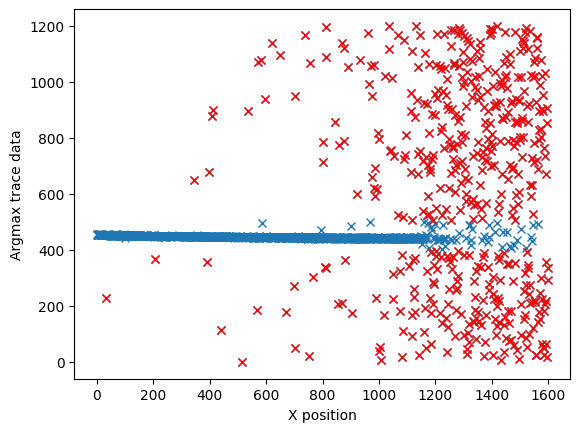

In [11]:
bad_pixels = (yvals < 400) | (yvals > 500)

plt.plot(xvals, yvals, "x")
plt.plot(xvals[bad_pixels], yvals[bad_pixels], "rx")
plt.ylabel("Argmax trace data")
plt.xlabel("X position");

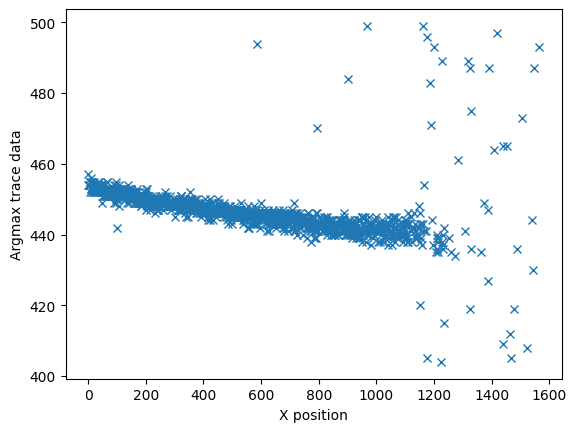

In [12]:
plt.plot(xvals[~bad_pixels], yvals[~bad_pixels], "x")
plt.ylabel("Argmax trace data")
plt.xlabel("X position");

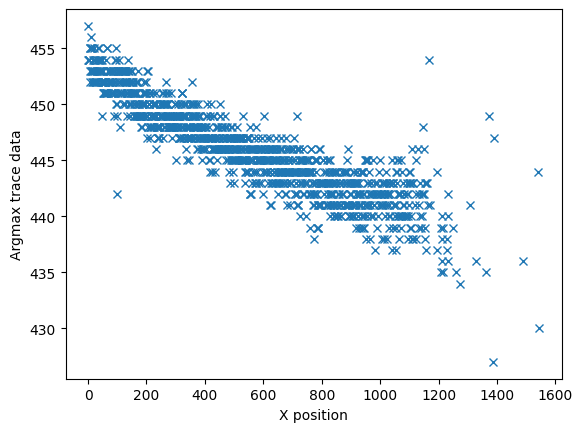

In [13]:
bad_pixels = (yvals < 425) | (yvals > 460)

plt.plot(xvals[~bad_pixels], yvals[~bad_pixels], "x")
plt.ylabel("Argmax trace data")
plt.xlabel("X position");

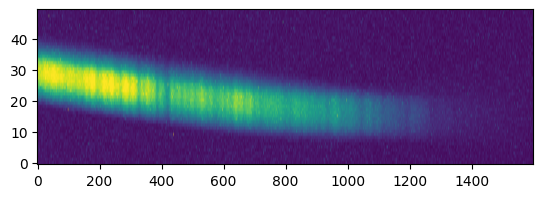

In [14]:
plt.imshow(image_array[425:475, :])
plt.gca().set_aspect(10)

In [15]:
# we use a cutout around the traced line, so the Y-values are from that cutout
# the `repeat` command here is used to extend our Y-axis position values, which are 425, 426, ... 475
# along the X-direction.  The indexing with [:, None] adds a "dummy" axis along the second (x) dimension,
# then `repeat` copies our Y-axis values.  The resulting array has the same shape as our weight array,
# which is image_array[425:475, :] minus the median
yaxis = np.repeat(np.arange(425, 475)[:, None], image_array.shape[1], axis=1)
background = np.median(image_array)
# moment 1 is the data-weighted average of the Y-axis coordinates
weighted_yaxis_values = np.average(
    yaxis, axis=0, weights=image_array[425:475, :] - background
)

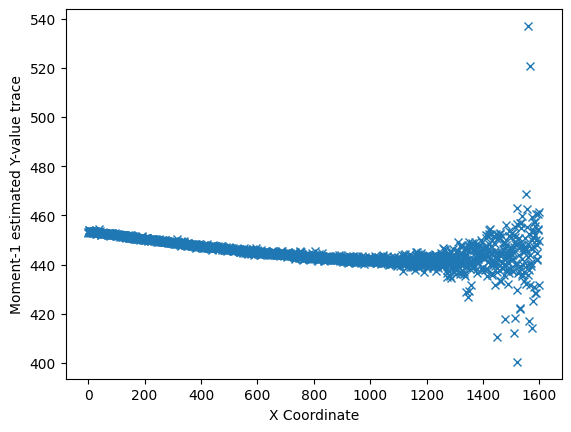

In [16]:
plt.plot(xvals, weighted_yaxis_values, "x")
plt.xlabel("X Coordinate")
plt.ylabel("Moment-1 estimated Y-value trace");

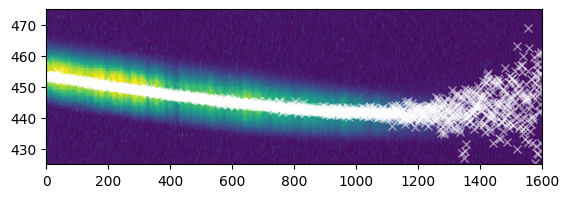

In [17]:
# we need to use the 'extent' keyword to have the axes correctly labeled
plt.imshow(image_array[425:475, :], extent=[0, image_array.shape[1], 425, 475])
plt.gca().set_aspect(10)  # we stretch the image out by 10x in the y-direction
plt.plot(xvals, weighted_yaxis_values, "wx", alpha=0.5)
plt.axis((0, 1600, 425, 475));

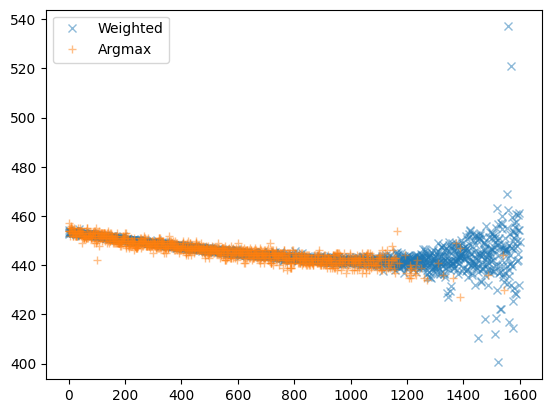

In [18]:
plt.plot(xvals, weighted_yaxis_values, "x", label="Weighted", alpha=0.5)
plt.plot(xvals[~bad_pixels], yvals[~bad_pixels], "+", label="Argmax", alpha=0.5)
plt.legend(loc="best");

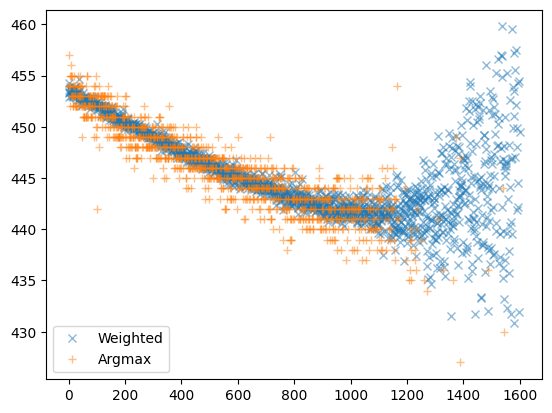

In [19]:
bad_moments = (weighted_yaxis_values > 460) | (weighted_yaxis_values < 430)

plt.plot(
    xvals[~bad_moments],
    weighted_yaxis_values[~bad_moments],
    "x",
    label="Weighted",
    alpha=0.5,
)
plt.plot(xvals[~bad_pixels], yvals[~bad_pixels], "+", label="Argmax", alpha=0.5)
plt.legend(loc="best");

In [21]:
# We fit a 2nd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(
    polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments]
)
fitted_polymodel

<Polynomial1D(2, c0=454.80138106, c1=-0.02381282, c2=0.00001121)>

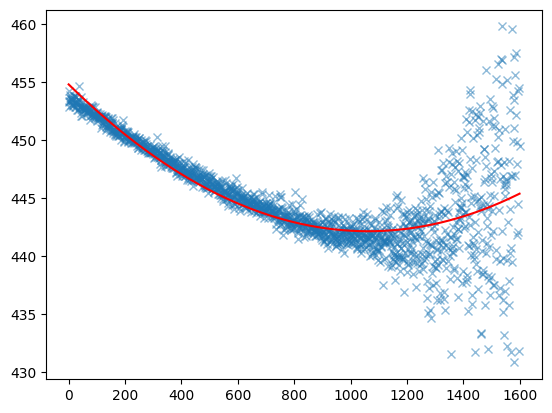

In [22]:
plt.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], "x", alpha=0.5)
plt.plot(xvals, fitted_polymodel(xvals), color="r");

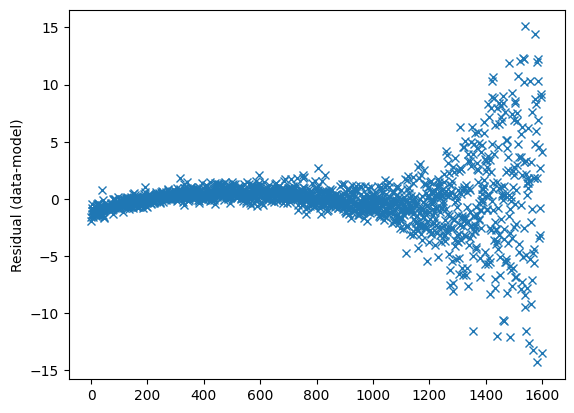

In [23]:
plt.plot(
    xvals[~bad_moments],
    weighted_yaxis_values[~bad_moments] - fitted_polymodel(xvals[~bad_moments]),
    "x",
)
plt.ylabel("Residual (data-model)");

In [24]:
polymodel = Polynomial1D(degree=3)
fitted_polymodel = linfitter(
    polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments]
)
fitted_polymodel

<Polynomial1D(3, c0=453.31622273, c1=-0.01256666, c2=-0.00000651, c3=0.00000001)>

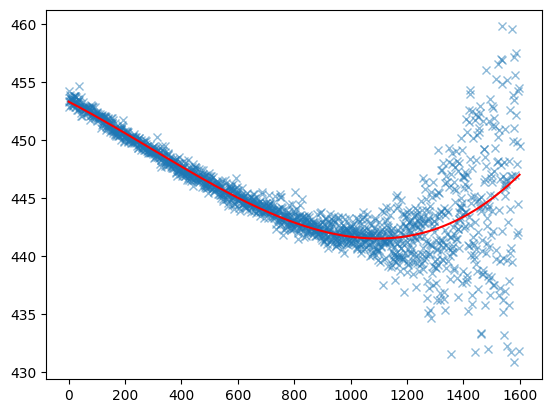

In [25]:
plt.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], "x", alpha=0.5)
plt.plot(xvals, fitted_polymodel(xvals), color="r");

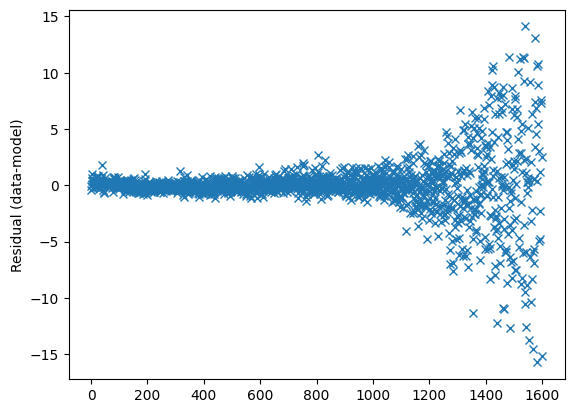

In [26]:
plt.plot(
    xvals[~bad_moments],
    weighted_yaxis_values[~bad_moments] - fitted_polymodel(xvals[~bad_moments]),
    "x",
)
plt.ylabel("Residual (data-model)");

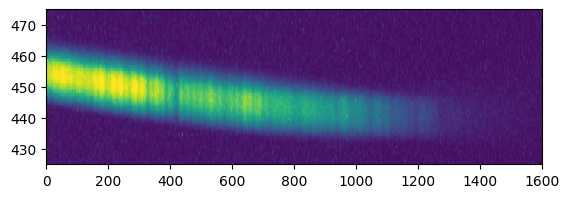

In [27]:
plt.imshow(image_array[425:475, :], extent=[0, image_array.shape[1], 425, 475])
plt.gca().set_aspect(10);

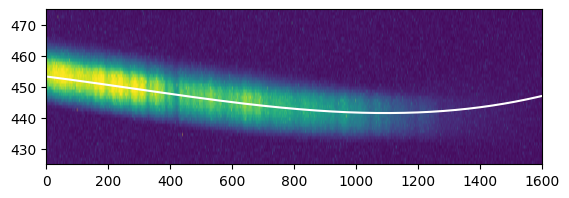

In [28]:
plt.imshow(image_array[425:475, :], extent=[0, image_array.shape[1], 425, 475])
plt.gca().set_aspect(10)
plt.plot(xvals, fitted_polymodel(xvals), "w")
plt.axis((0, 1600, 425, 475));

In [29]:
polymodel = Polynomial1D(degree=3)
fitted_polymodel = linfitter(
    polymodel,
    xvals[(~bad_moments) & (xvals < 1200)],
    weighted_yaxis_values[(~bad_moments) & (xvals < 1200)],
)
fitted_polymodel

<Polynomial1D(3, c0=453.63074008, c1=-0.01596396, c2=0.00000083, c3=0.)>

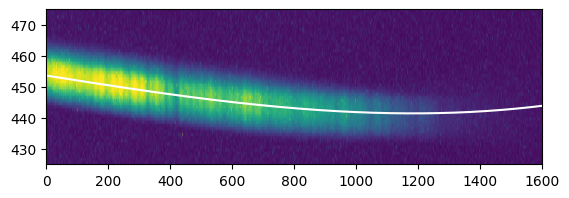

In [30]:
plt.imshow(image_array[425:475, :], extent=[0, image_array.shape[1], 425, 475])
plt.gca().set_aspect(10)
plt.plot(xvals, fitted_polymodel(xvals), "w")
plt.axis((0, 1600, 425, 475));

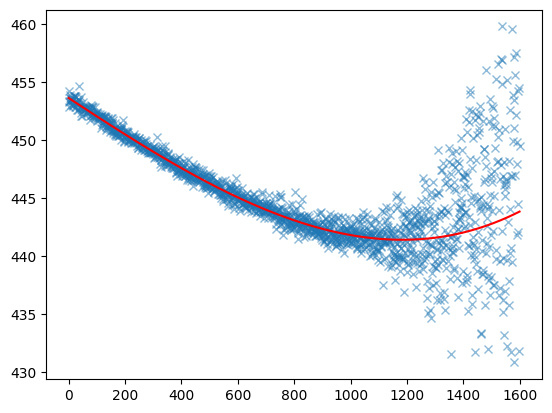

In [31]:
plt.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], "x", alpha=0.5)
plt.plot(xvals, fitted_polymodel(xvals), color="r");

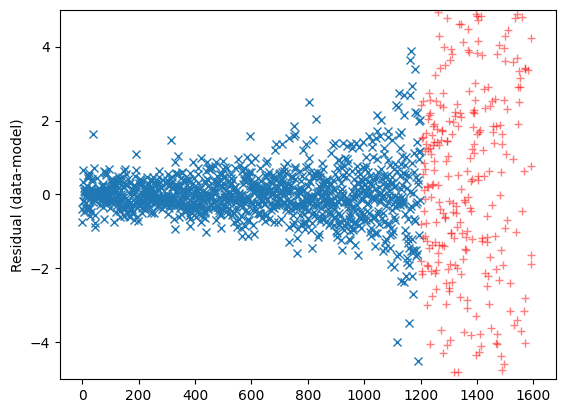

In [32]:
plt.plot(
    xvals[~bad_moments & (xvals < 1200)],
    weighted_yaxis_values[~bad_moments & (xvals < 1200)]
    - fitted_polymodel(xvals[~bad_moments & (xvals < 1200)]),
    "x",
)
plt.plot(
    xvals[~bad_moments & (xvals > 1200)],
    weighted_yaxis_values[~bad_moments & (xvals > 1200)]
    - fitted_polymodel(xvals[~bad_moments & (xvals > 1200)]),
    "r+",
    alpha=0.5,
)
plt.ylim(-5, 5)
plt.ylabel("Residual (data-model)");

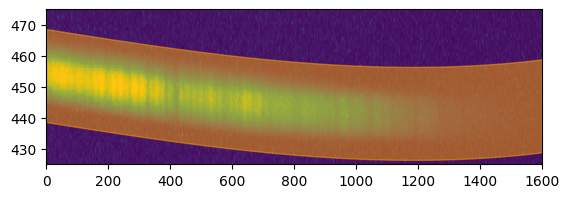

In [33]:
plt.imshow(image_array[425:475, :], extent=[0, image_array.shape[1], 425, 475])
plt.gca().set_aspect(10)
plt.fill_between(
    xvals,
    fitted_polymodel(xvals) - 15,
    fitted_polymodel(xvals) + 15,
    color="orange",
    alpha=0.5,
)
plt.axis((0, 1600, 425, 475));

In [34]:
# start by taking +/- 15 pixels
npixels_to_cut = 15
trace_center = fitted_polymodel(xvals)
cutouts = np.array(
    [
        image_array[int(yval) - npixels_to_cut : int(yval) + npixels_to_cut, ii]
        for yval, ii in zip(trace_center, xvals)
    ]
)
cutouts.shape

(1600, 30)

In [35]:
cutouts = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])

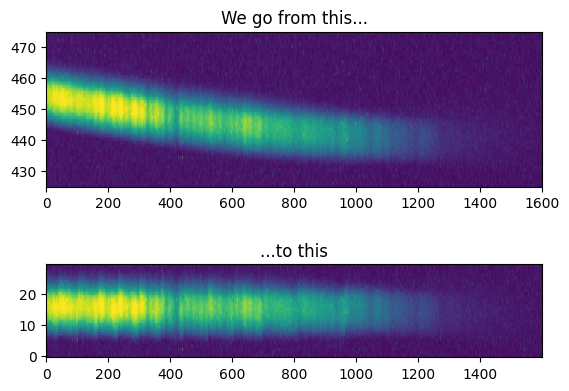

In [36]:
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(image_array[425:475, :], extent=[0, image_array.shape[1], 425, 475])
ax1.set_aspect(10)
ax1.set_title("We go from this...")
ax2 = plt.subplot(2, 1, 2)
ax2.imshow(cutouts.T)
ax2.set_title("...to this")
ax2.set_aspect(10)

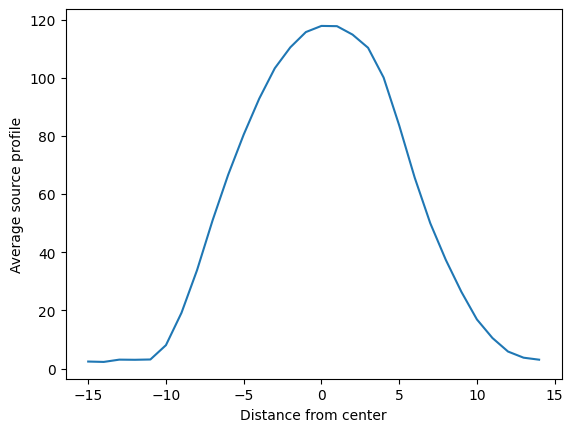

In [37]:
mean_trace_profile = (cutouts - background).mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
plt.plot(trace_profile_xaxis, mean_trace_profile)
plt.xlabel("Distance from center")
plt.ylabel("Average source profile");

In [38]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(
    model=guess, x=trace_profile_xaxis, y=mean_trace_profile
)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile

<Gaussian1D(amplitude=123.84846797, mean=0.17719819, stddev=5.10872134)>

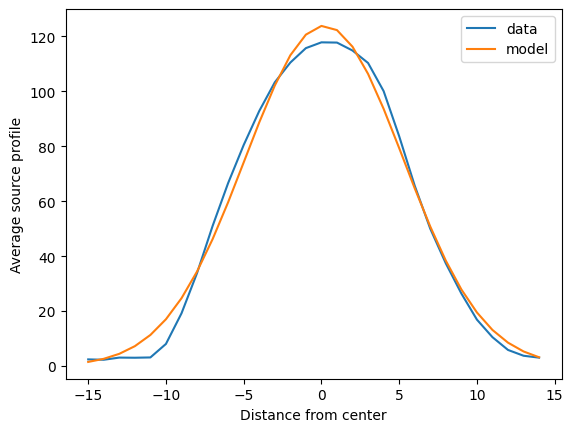

In [39]:
plt.plot(trace_profile_xaxis, mean_trace_profile, label="data")
plt.plot(trace_profile_xaxis, model_trace_profile, label="model")
plt.legend(loc="best")
plt.xlabel("Distance from center")
plt.ylabel("Average source profile");

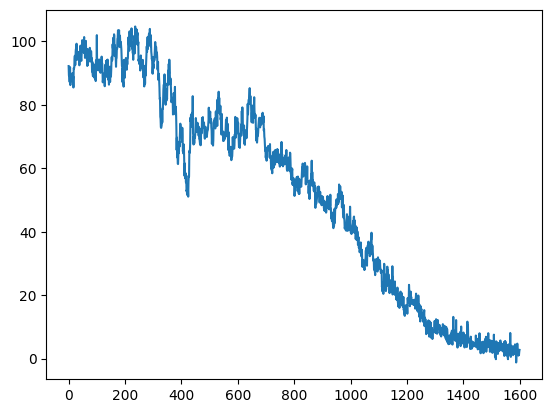

In [40]:
average_spectrum = (cutouts - background).mean(axis=1)
plt.plot(average_spectrum);

In [41]:
trace_avg_spectrum = np.array(
    [
        np.average(
            image_array[int(yval) - npixels_to_cut : int(yval) + npixels_to_cut, ii]
            - background,
            weights=mean_trace_profile,
        )
        for yval, ii in zip(trace_center, xvals)
    ]
)

In [42]:
gaussian_trace_avg_spectrum = np.array(
    [
        np.average(
            image_array[int(yval) - npixels_to_cut : int(yval) + npixels_to_cut, ii]
            - background,
            weights=model_trace_profile,
        )
        for yval, ii in zip(trace_center, xvals)
    ]
)

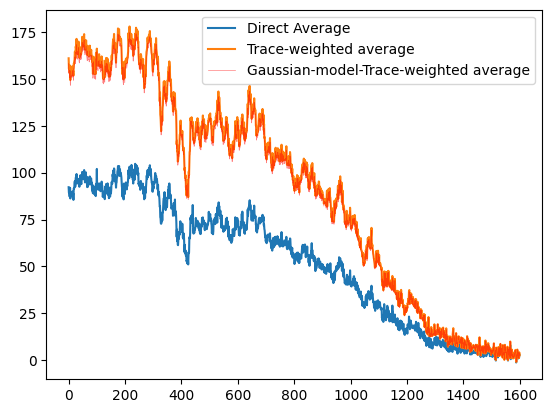

In [43]:
plt.plot(average_spectrum, label="Direct Average")
plt.plot(trace_avg_spectrum, label="Trace-weighted average")
plt.plot(
    gaussian_trace_avg_spectrum,
    label="Gaussian-model-Trace-weighted average",
    alpha=0.5,
    linewidth=0.5,
    color="r",
)
plt.legend(loc="best");

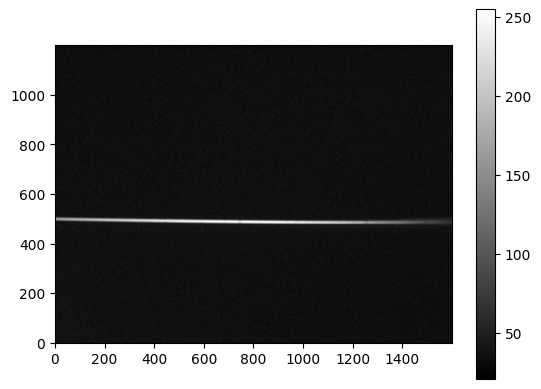

In [45]:
image_array_2 = np.array(Image.open("deneb_3s_13.63g_1.bmp"))
plt.imshow(image_array_2, cmap="gray")
plt.colorbar();

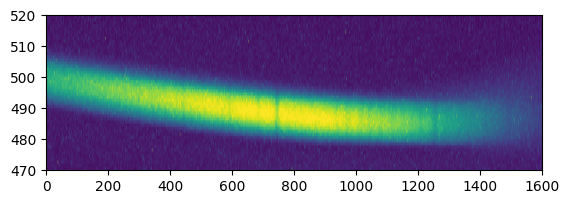

In [46]:
plt.imshow(image_array_2[470:520, :], extent=[0, 1600, 470, 520])
plt.gca().set_aspect(10)

In [47]:
yaxis2 = np.repeat(np.arange(470, 520)[:, None], image_array_2.shape[1], axis=1)
weighted_yaxis_values2 = np.average(
    yaxis2, axis=0, weights=image_array_2[470:520, :] - np.median(image_array_2)
)
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

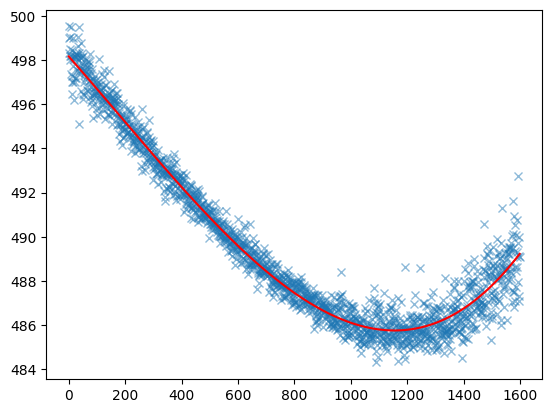

In [48]:
plt.plot(xvals, weighted_yaxis_values2, "x", alpha=0.5)
plt.plot(xvals, trace_center2, color="r");

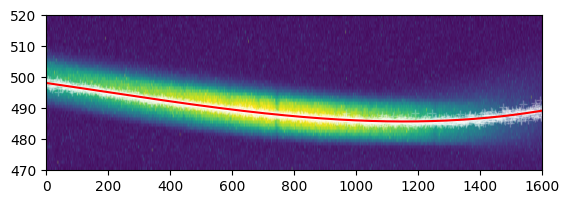

In [49]:
plt.imshow(image_array_2[470:520, :], extent=[0, 1600, 470, 520])
plt.plot(xvals, weighted_yaxis_values2, "w+", alpha=0.25)
plt.plot(xvals, trace_center2, color="r")
plt.gca().set_aspect(10)

In [50]:
spectrum2 = np.array(
    [
        np.average(
            image_array_2[int(yval) - npixels_to_cut : int(yval) + npixels_to_cut, ii]
            - np.median(image_array_2),
            weights=mean_trace_profile,
        )
        for yval, ii in zip(trace_center2, xvals)
    ]
)

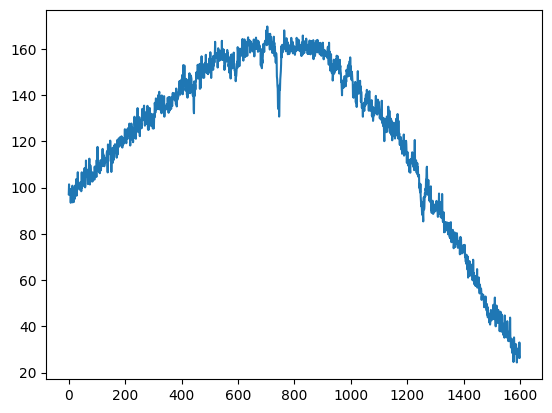

In [51]:
plt.plot(spectrum2);